Basic AI Agent

In [ ]:
!pip install langgraph langchain-google-genai google-generativeai

INFO: pip is looking at multiple versions of google-generativeai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of google-generativeai to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 12.8 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
import os

os.environ["GOOGLE_API_KEY"] = userdata.get('GEMINI_API_KEY')
os.environ["LANGSMITH_API_KEY"] = userdata.get('LANGSMITH_API_KEY')
os.environ['LANGCHAIN_TRACING_V2'] = ('LANGCHAIN_TRACING_V2')
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'

In [ ]:
#Basic Imports
from typing import TypedDict, List
from langchain_core.messages import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END

In [ ]:
#Create State
class AgentState(TypedDict):
  """State structure for our agent"""
  messages: List[HumanMessage]

In [ ]:
#Initialize the LLM
llm = ChatGoogleGenerativeAI(model = "gemini-2.0-flash", temparature = 0.6, google_api_key=userdata.get('GEMINI_API_KEY'))

In [ ]:
#Create Node
def process(state: AgentState) -> AgentState:
    """ This node takes user messages and replies useing LLM"""
    response = llm.invoke(state["messages"])
    print(f"AI: {response.content}")
    return state

In [ ]:
graph = StateGraph(AgentState)
graph.add_node("process", process)
graph.add_edge(START, "process")
graph.add_edge("process", END)

agent = graph.compile()

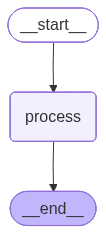

In [ ]:
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

In [ ]:
#Call the graph
agent.invoke({"messages": [HumanMessage(content = "Hello, my name is Nethra")]})

AI: Hello Nethra! It's nice to meet you. How can I help you today?


{'messages': [HumanMessage(content='Hello, my name is Nethra', additional_kwargs={}, response_metadata={})]}

In [ ]:
#Make this interactive
while True:
  user_input = input("User: ")
  if user_input.lower() == "quit":
    break
  agent.invoke({"messages": [HumanMessage(content = user_input)]})

User: Hello, I am Neth
AI: Hello Neth! It's nice to meet you. How can I help you today?
User: quit


Agent 2: Simple Agent with Memory

In [ ]:
#Basic Imports
from typing import Union
from langchain_core.messages import AIMessage

In [ ]:
class AgentState(TypedDict):
  """State structure for our agent"""
  messages: List[Union[HumanMessage, AIMessage]]

In [ ]:
#Create Node
def process_with_memory(state: AgentState) -> AgentState:
  """This node takes user messages and replies and also maintains the context from previous messages"""

  response = llm.invoke(state["messages"])

  state["messages"].append(AIMessage(content = response.content))
  print(f"AI: {response.content}")
  print(f"Current Conversation has {len(state['messages'])} messages")

  return state

In [ ]:
memory_graph = StateGraph(AgentState)
memory_graph.add_node("process_with_memory", process_with_memory)
memory_graph.add_edge(START, "process_with_memory")
memory_graph.add_edge("process_with_memory", END)

memory_agent = memory_graph.compile()

In [ ]:
conversation_history = []

while True:
  user_input = input("You: ")
  if user_input.lower() == "quit":
    break
  conversation_history.append(HumanMessage(content = user_input))
  result = memory_agent.invoke({"messages": conversation_history})

  conversation_history = result["messages"]

You: Hello, I am Neth
AI: Hello Neth, it's nice to meet you! How can I help you today?
Current Conversation has 2 messages
You: quit


## Agent 3: Sequential Agent
Analyze Sentiment, Categorize query and then answer

In [ ]:
from langchain_core.messages import SystemMessage

In [ ]:
class sequentialAgentState(TypedDict):
  """State structure for our agent"""

  messages: List[Union[HumanMessage, AIMessage]]
  sentiment: str
  category : str
  final_response: str

In [ ]:
#Node 1: Analyze the Sentiment

def analyze_message(state: sequentialAgentState) -> sequentialAgentState:
  """Analyze the sentiment of the user message"""
  user_message = state["messages"][-1].content

  #sentiment analysis
  sentiment_analysis = [SystemMessage(content = "You are a helpful assistant that analyzes")]

In [ ]:
#Second Node: Categorization
def categorize_message(state: sequentialAgentState) -> sequentialAgentState:
  """Categorize the user message"""
  user_message = state["messages"][-1].content

  category_prompt = [SystemMessage(content = "Categorize the message into ONE of the follwoing: QUESTION, STATEMENT, GREETING, or COMMAND"),
                     HumanMessage(content = f"Categorize the follwing message: {user_message}")]

  category = llm.invoke(category_prompt).content
  state["category"] = category
  print(f"Category: {category}")

  return state

In [ ]:
#Node 3: REPLY TO USER
def generate_contextual_response(state: sequentialAgentState) -> sequentialAgentState:
  """Generate a contextual response to the user message"""
  sentiment = state["sentiment"]
  category = state["category"]
  user_message = state["messages"][-1].content

  response_prompt = [SystemMessage(content)]

  response = llm.invoke(response_prompt).content
  state["messages"].append(AIMessage(content = response.content))
  state["final_response"] = response
  print(f"AI: {response}")

  return state

In [ ]:
sequential_graph = StateGraph(sequentialAgentState)
sequential_graph.add_node("analyze_message", analyze_message)
sequential_graph.add_node("categorize_message", categorize_message)
sequential_graph.add_node("generate_contextual_response", generate_contextual_response)
sequential_graph.add_edge(START, "analyze_message")
sequential_graph.add_edge("analyze_message", "categorize_message")

## Last One: ReAct Agent
Basic ReAct based agent that can perform addition and multiplication using tools

In [ ]:
from typing import Annotated, Sequence
from langchain_core.messages import BaseMessage, ToolMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

In [ ]:
class AgentState(TypedDict):
  """State of the ReAct Agent"""
  messages: Annotated[Sequence[BaseMessage], add_messages]

In [ ]:
@tool
def add(a: int, b: int) -> int:
  """Adds two numbers a & b together"""
  result = a + b
  return result

@tool
def multiply(a: int, b: int) -> int:
  """Multiplies two numbers a & b together"""
  result = a * b
  return result

In [ ]:
tools = [add, multiply]
llm_with_tools = llm.bind_tools(tools)

In [ ]:
#Agent Node
def call_model(state: AgentState) -> AgentState:
  """This is the main agent which calls the tools and perform the action"""
  system_message = SystemMessage(content = "You are a helpful calculator assistant. Use the available tools to perform calculations when needed.")

  response = llm_with_tools.invoke([system_message]+ state["messages"])

  print(f"AI:")
  return{"messages": [response]}

In [ ]:
#Conditional Edge
def should_continue(state: AgentState) -> str:
  """Decision function to determine the next step in the graph"""
  messages = state["messages"]
  last_message = messages[-1]

  # Check if last AI message has tool calls
  if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
    print(f"CONTINUE TO TOOLS")
    return "tools"
  else:
    print(f"END: GIVE FINAL ANSWER")
    return "end"

In [ ]:
# initialize & compile
graph = StateGraph(AgentState)
graph.add_node("llm", call_model)
tool_node = ToolNode(tools)
graph.add_node("tools", tool_node)
graph.set_entry_point("llm")
graph.add_conditional_edges(
    "llm",
    should_continue,
    {
        "tools": "tools",
        "end": END
    }
)

graph.add_edge("tools", "llm")
react_agent = graph.compile()

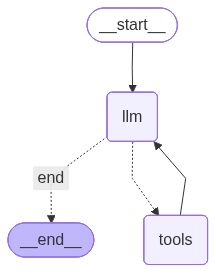

In [ ]:
from IPython.display import Image, display
display(Image(react_agent.get_graph().draw_mermaid_png()))

In [ ]:
input = {
    "messages": [HumanMessage(content = "What is 15 times 8, then add 42 to it.")]
}
result = react_agent.invoke(input)
final_message = result["messages"][-1]
print(f"Final answer: {final_message}")

AI:
CONTINUE TO TOOLS
AI:
CONTINUE TO TOOLS
AI:
END: GIVE FINAL ANSWER
Final answer: content='15 times 8 is 120, and adding 42 to that is 162.' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run--308480d1-43d4-4c4f-8b0f-311e2217c048-0' usage_metadata={'input_tokens': 81, 'output_tokens': 24, 'total_tokens': 105, 'input_token_details': {'cache_read': 0}}
